In [ ]:

import datetime
from csbdeep.io import load_training_data
from csbdeep.utils import axes_dict
from projection_upsampling_network.projection_upsampling_class import ProjectionUpsamplingConfig, ProjectionUpsampling
import tensorflow as tf
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, mean_squared_error as mse, structural_similarity as ssim, normalized_root_mse as nrmse_sklearn
import csv
import datetime
from csbdeep.utils import normalize
from wandb.integration.keras import WandbCallback
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from csbdeep.utils.tf import keras_import, BACKEND as K
from csbdeep.internals import nets
import tifffile 
import io
import os
import albumentations as A
import cv2

2025-04-21 21:26:15.799099: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-21 21:26:15.969645: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-21 21:26:17.308755: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/student/a/asarker/.conda/envs/thesis/lib/:/home/student/a/asarker/.conda/envs/thesis/lib/python3.10/site-packages/nvidia/cudnn/lib:/home/student/a/asarker/.conda/envs/thesis/lib/:/home/student/a/asarker/.co

In [2]:
root_dir = './dataset/microtubules'
model_dir = './trained_model/microtubules/'

Path(model_dir).mkdir(parents=True,exist_ok=True)
output_dir = model_dir + '/output'
Path(output_dir).mkdir(parents=True,exist_ok=True)

train_data_file = f"{root_dir}/train/Train/SR/microtubules_SR_trainig.npz"
val_data_file = f"{root_dir}/val/Train/SR/microtubules_SR_trainig.npz"
log_dir = "logs/fitSR/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [3]:
# load the trainid data
(X,Y), _ , axes = load_training_data(train_data_file, verbose=True)
print()

# load the trainid data
(X_val,Y_val), _ , axes = load_training_data(val_data_file, verbose=True)

print('show infromation regading data and shape')
print()
print('trainig data')
print('__'*20)
print('X shape:', X.shape)
print('Y shape:', Y.shape)
print('axes:', axes)
print()
print('validation data')
print('__'*20)
print('X_val shape:', X_val.shape)
print('Y_val shape:', Y_val.shape)
print('axes:', axes)

number of training images:	 25
number of validation images:	 0
image size (3D):		 (9, 128, 128)
axes:				 SZYXC
channels in / out:		 1 / 1

number of training images:	 15
number of validation images:	 0
image size (3D):		 (9, 128, 128)
axes:				 SZYXC
channels in / out:		 1 / 1
show infromation regading data and shape

trainig data
________________________________________
X shape: (25, 9, 128, 128, 1)
Y shape: (25, 1, 256, 256, 1)
axes: SZYXC

validation data
________________________________________
X_val shape: (15, 9, 128, 128, 1)
Y_val shape: (15, 1, 256, 256, 1)
axes: SZYXC


In [4]:


batch_size = 8
epochs = 15
unet_n_depth = 2
train_loss = 'mse'
unet_n_first = 4
unet_kern_size=3


train_learning_rate=0.0004
upsampling_factor = 2
proj_n_depth= 1
proj_n_filt=4
proj_n_conv_per_depth= 1
train_steps_per_epoch =X.shape[0]//batch_size

total_data, height, width, channels = X.shape[0], X.shape[2], X.shape[3], X.shape[1]
c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]


In [5]:
def create_augmenter():


    H , W = 256 , 256 # I need same size for affine transfromation of the input and GT


    return  A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            # A.RandomBrightnessContrast(p=0.5),
            # Affine transformation: scales, shifts, and shears
            A.Affine(
                scale=(0.8, 1.1),
                translate_percent=(-0.2, 0.2),
                shear=(-10, 10),
                p=0.5,
                keep_ratio=True, 
                border_mode=cv2.BORDER_REFLECT
            ),
            

            # Random crop (taking 80% of the original size) followed by a resize
            A.RandomCrop(height=int(0.8 * H), width=int(0.8 * W), p=0.5),
            A.Resize(height=H, width=W)
        ], is_check_shapes=True)


In [6]:
config = ProjectionUpsamplingConfig(axes, 
                                      n_channel_in, 
                                      n_channel_out, 
                                      unet_n_depth=unet_n_depth,
                                      train_loss=train_loss,
                                      unet_n_first=unet_n_first,
                                      unet_kern_size=unet_kern_size,
                                      train_epochs=epochs, 
                                      train_batch_size = batch_size, 
                                      train_learning_rate = train_learning_rate,
                                      upsampling_factor=upsampling_factor, 
                                      proj_n_depth=proj_n_depth,
                                      proj_n_filt=proj_n_filt,
                                      proj_n_conv_per_depth=proj_n_conv_per_depth,
                                      train_steps_per_epoch= train_steps_per_epoch,
                                      train_reduce_lr   =  {'factor': 0.5, 'patience': 4},
                                      train_tensorboard=False
                                    
                                  
                                  
                                      )

In [7]:
vars(config)

{'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'probabilistic': False,
 'unet_n_depth': 2,
 'unet_n_first': 4,
 'unet_kern_size': 3,
 'train_batch_size': 8,
 'train_epochs': 15,
 'train_learning_rate': 0.0004,
 'train_loss': 'mse',
 'upsampling_factor': 2,
 'train_steps_per_epoch': 3,
 'proj_n_depth': 1,
 'proj_n_filt': 4,
 'proj_n_conv_per_depth': 1,
 'train_reduce_lr': {'factor': 0.5, 'patience': 4},
 'train_tensorboard': False,
 'n_dim': 3,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'unet_residual': True,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, None, 1),
 'proj_axis': 'Z',
 'proj_kern': (3, 3, 3),
 'proj_pool': (1, 2, 2)}

In [8]:
model = ProjectionUpsampling(config, name = 'MT-training_tutorial', basedir=model_dir)

shape of input: (None, None, None, None, 1)


/home/student/a/asarker/.conda/envs/thesis/lib/python3.10/site-packages/csbdeep/models/base_model.py:203: UserWarning: output path for model already exists, files may be overwritten: /share/klab/argha/projection_upsampling_network/examples/trained_model/microtubules/MT-training_tutorial
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))
2025-04-21 21:26:29.655823: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/student/a/asarker/.conda/envs/thesis/lib/python3.10/site-packages/cv2/../../lib64:/home/student/a/asarker/.conda/envs/thesis/lib/:/home/student/a/asarker/.conda/envs/thesis/lib/python3.10/site-packages/nvidia/cudnn/lib:/home/student/a/asarker/.conda/envs/thesis/lib/:/home/student/a/asarker/.conda/envs/thesis/lib/python3.10/site-packages/nvidia/cudnn/l

In [9]:
print(model.proj_params)

ProjectionParameters(axis='Z', n_depth=1, n_filt=4, n_conv_per_depth=1, kern=(3, 3, 3), pool=(1, 2, 2))


In [10]:
model.prepare_for_training()
model.callbacks = [cb for cb in model.callbacks if not isinstance(cb, TensorBoard)]
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1
)
model.callbacks.append(early_stopping)
augmenter_albu = create_augmenter()

from care callbacks: [<keras.callbacks.ReduceLROnPlateau object at 0x7f39806d8280>, <keras.callbacks.TerminateOnNaN object at 0x7f39806dbfd0>, <keras.callbacks.ModelCheckpoint object at 0x7f39806aab90>, <keras.callbacks.ModelCheckpoint object at 0x7f39806aace0>]


In [11]:
history = model.train(X, Y, validation_data=(X_val, Y_val), augmenter=augmenter_albu)

Epoch 1/15
Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x7f3984b731c0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: K.mean(x, axis=-1)

Match 1:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x7f3984b731c0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: K.mean(x, axis=-1)

Match 1:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function _mean_or_not.<locals>

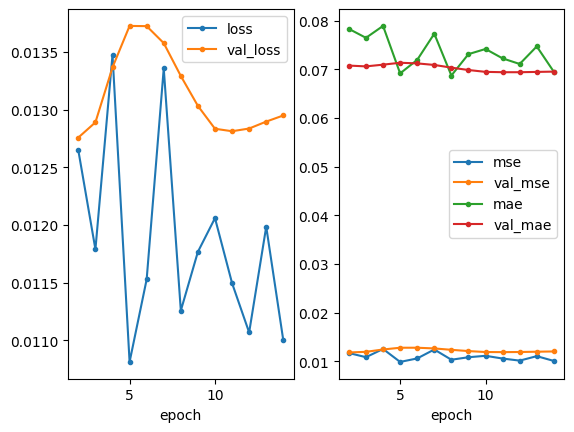

In [14]:
def plot_history(history, *keys, save_path=None, **kwargs):
    """Plot (Keras) training history returned by :func:`CARE.train` and save the plot if save_path is provided."""
    import matplotlib.pyplot as plt

    logy = kwargs.pop('logy', False)

    if all((isinstance(k, str) for k in keys)):
        w, keys = 1, [keys]
    else:
        w = len(keys)

    plt.gcf()
    for i, group in enumerate(keys):
        plt.subplot(1, w, i + 1)
        for k in ([group] if isinstance(group, str) else group):
            # Skip the first two epochs by slicing the lists
            plt.plot(history.epoch[2:], history.history[k][2:], '.-', label=k, **kwargs)
            if logy:
                plt.gca().set_yscale('log', nonposy='clip')
        plt.xlabel('epoch')
        plt.legend(loc='best')

    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()


plot_history(history, ['loss','val_loss'], ['mse','val_mse','mae','val_mae'])


predictions shape = (5, 256, 256)


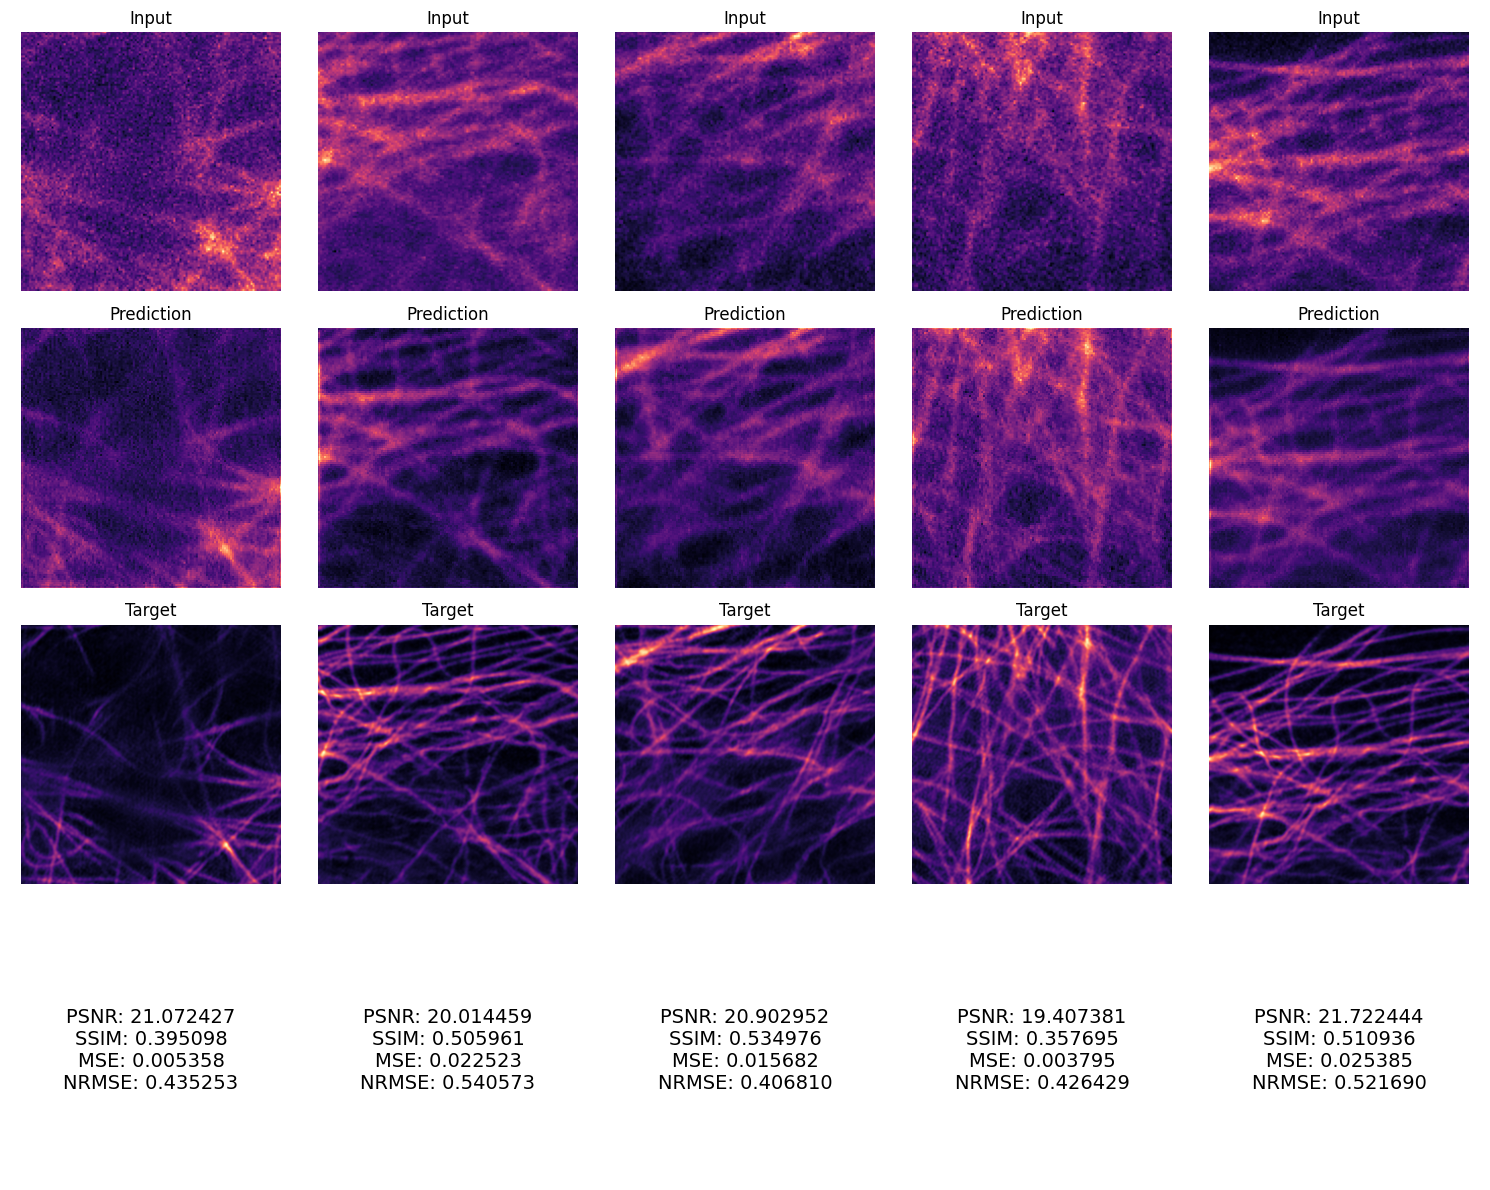

In [15]:
np.random.seed(42)
indices = np.random.choice(X_val.shape[0], 5, replace=False)


x_feed = X_val[indices].squeeze()
y_feed = Y_val[indices].squeeze()


#now lets get all the predictions 
predictions = np.array([model.predict(x_feed[i], axes='ZYX') for i in range(x_feed.shape[0])])

print(f'predictions shape = {predictions.shape}')
# normalize the data to calculate the evaluaiton metricies
predictions = normalize(predictions)
y_feed = normalize(y_feed)



fig, axes = plt.subplots(4, 5, figsize=(15, 12))

for i in range(5):
    inp = x_feed[i].transpose(1, 2, 0)  # (128,128,9)
    axes[0, i].imshow(inp[..., 0], cmap='magma')
    axes[0, i].set_title("Input")
    axes[0, i].axis('off')

    axes[1, i].imshow(predictions[i], cmap='magma')
    axes[1, i].set_title("Prediction")
    axes[1, i].axis('off')

    axes[2, i].imshow(y_feed[i], cmap='magma')
    axes[2, i].set_title("Target")
    axes[2, i].axis('off')

    score_text = (
        f"PSNR: {psnr(y_feed[i], predictions[i], data_range=predictions[i].max() - predictions[i].min()):.6f}\n"
        f"SSIM: {ssim(y_feed[i], predictions[i], data_range=predictions[i].max() - predictions[i].min()):.6f}\n"
        f"MSE: {mse(y_feed[i], predictions[i]):.6f}\n"
        f"NRMSE: {nrmse_sklearn(y_feed[i], predictions[i]):.6f}"
    )
    axes[3, i].text(0.5, 0.5, score_text, ha='center', va='center', fontsize=14)
    axes[3, i].axis('off')

plt.tight_layout()
plt.show()
# plt.savefig(f'{output_dir}/predictions.png')


